<ipython-input-2-ddda86cf4807>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler


Epoch 1, Loss: 0.1034
Epoch 2, Loss: 0.0287
Epoch 3, Loss: 0.0230
Epoch 4, Loss: 0.0204
Epoch 5, Loss: 0.0188
Epoch 6, Loss: 0.0178
Epoch 7, Loss: 0.0170
Epoch 8, Loss: 0.0165
Epoch 9, Loss: 0.0159
Epoch 10, Loss: 0.0156
Epoch 11, Loss: 0.0153
Epoch 12, Loss: 0.0150
Epoch 13, Loss: 0.0149
Epoch 14, Loss: 0.0147
Epoch 15, Loss: 0.0146
Epoch 16, Loss: 0.0144
Epoch 17, Loss: 0.0143
Epoch 18, Loss: 0.0143
Epoch 19, Loss: 0.0141
Epoch 20, Loss: 0.0140
Evaluating Multivariate Forecasting...
MSE: 0.0107, MAE: 0.0682


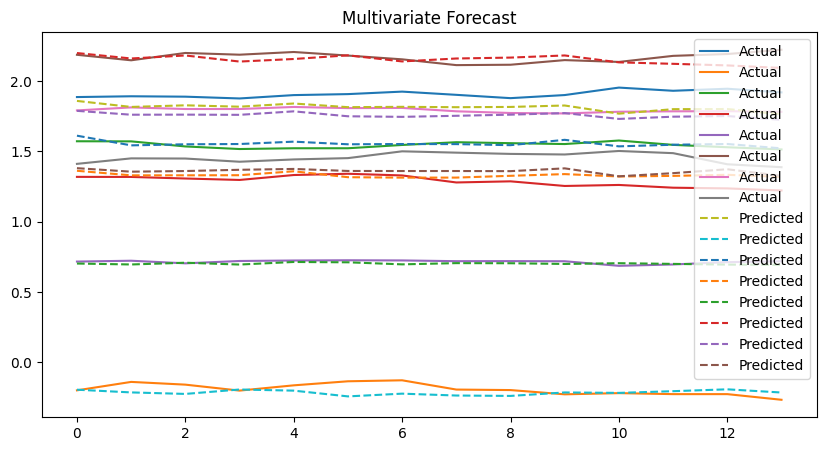

Evaluating Univariate Forecasting...
MSE: 0.0114, MAE: 0.0822


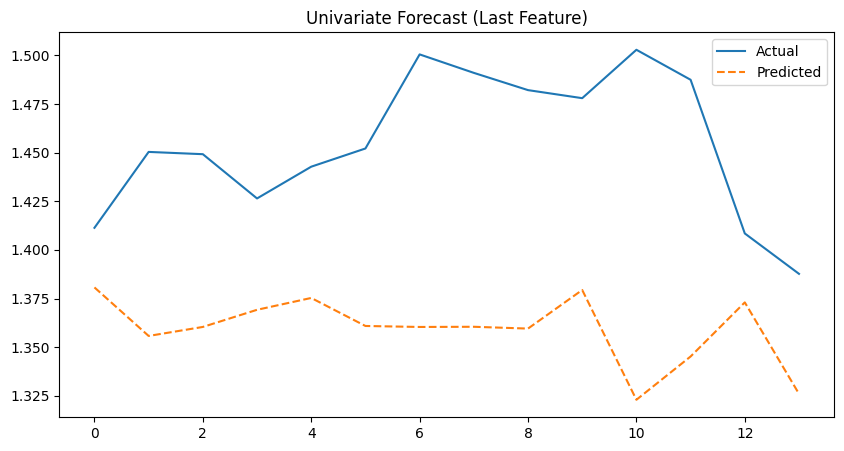

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load the Exchange dataset
def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['date'])  # Ensure the 'date' column is properly parsed
    df.set_index('date', inplace=True)
    return df

# Prepare dataset for DLinear model
def prepare_data(df, seq_len=96, pred_len=14):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(df_scaled) - seq_len - pred_len):
        X.append(df_scaled[i:i+seq_len])
        y.append(df_scaled[i+seq_len:i+seq_len+pred_len])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

# Define the DLinear model
class DLinear(nn.Module):
    def __init__(self, input_dim, seq_len, pred_len):
        super(DLinear, self).__init__()
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to (batch, feature, seq_len)
        out = self.linear(x)
        return out.permute(0, 2, 1)  # Reshape back

# Train function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate function
def evaluate_model(model, X_test, y_test, scaler, univariate=False):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_test = y_test.numpy()

    if univariate:
        y_pred = y_pred[:, :, -1]
        y_test = y_test[:, :, -1]

    mse = np.mean((y_pred - y_test) ** 2)
    mae = np.mean(np.abs(y_pred - y_test))

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")
    return y_pred, y_test

# Visualization function
def plot_results(y_pred, y_test, title="Forecast vs Actual"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[0], label="Actual")
    plt.plot(y_pred[0], label="Predicted", linestyle='dashed')
    plt.legend()
    plt.title(title)
    plt.show()

# Main script
if __name__ == "__main__":
    filepath = "exchange_rate.csv"  # Change if needed
    df = load_data(filepath)

    seq_len = 96
    pred_len = 14

    X, y, scaler = prepare_data(df, seq_len, pred_len)
    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    model = DLinear(input_dim=X.shape[2], seq_len=seq_len, pred_len=pred_len)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, epochs=20)

    print("Evaluating Multivariate Forecasting...")
    y_pred_multi, y_test_multi = evaluate_model(model, X_test, y_test, scaler)
    plot_results(y_pred_multi, y_test_multi, "Multivariate Forecast")

    print("Evaluating Univariate Forecasting...")
    y_pred_uni, y_test_uni = evaluate_model(model, X_test, y_test, scaler, univariate=True)
    plot_results(y_pred_uni, y_test_uni, "Univariate Forecast (Last Feature)")

In [3]:
import wandb

In [5]:
# Initialize Weights & Biases
wandb.init(project="dlinear-exchange-forecast")

In [8]:
# Save W&B link
with open("wandb_dashboard.txt", "w") as f:
  f.write(f"W&B Dashboard: {wandb.run.get_url()}\n")